# Data collection method 

#### Collecting fire images 
The secondary source fire image dataset used in this project are primarily from the following links: 

https://drive.google.com/file/d/11KBgD_W2yOxhJnUMiyBkBzXDPXhVmvCt/view

https://www.kaggle.com/phylake1337/fire-dataset

https://github.com/cair/Fire-Detection-Image-Dataset/find/master

The first dataset contains 1405 images of fires. There are mostly urban fire and few wildfires. But the data is not cleaned. It contains many images without fire: site before and after the fire, firefighters and their equipment only, map of the area of the fire, a cartoon of fire, etc. So the data cleaning has been done. All black and white images are removed. All images without fire or smoke are removed. All the repeated images had been removed. It was a challenge whether or not to keep the picture involving fire damage and lots of ash. Ash might be the indication that there was a fire. But as a fire detection tool there might be little interest in the post damage picture. So I decided to remove those images as well. After removing all the irrelevant images we retain 768 images in our dataset. In total, I removed 637 images from the dataset. Which is all human labor. 

 

The second dataset contains 755 images containing fire and 244 images without fire. Clearly, there is a disparity in the number of images in two categories. Also, the fire images mostly contain wildfire and few urban fires. However, the non-fire images are mostly forest images. A significant amount of fire images are taken at night while the non-fire images are taken on the day. So, the non-fire dataset is not representative. So, I use a non-fire dataset from other sources to make it more representative. Throughout this project JEPG image with RGB, the format is chosen as default. The fire images in this dataset are in .png format. So conversion was necessary to merge into the final dataset. The labels were all correct in this set but there were few duplicate images. After removing all the duplicates there are 717 fire images. 


The third dataset contains 110 fire images. No cleaning is done in this dataset other than removing one duplicate. This dataset contains non-fire images as well. But they are mostly indoor images. Almost all images are taken at day. So we have 1595 fire images in total. However, the dataset is not representative of all fire cases. Limitations of the dataset. 
- There are no indoor fire images. 
- There are no road/highway/vehicle fire images. 

So I use web scraping techniques to collect more fire images, which I will discuss shortly. So in total, we have 2000 fire images. 

#### Collecting non-fire images

There is a huge collection of images in 8 Scene Categories Dataset which we may use for non-fire images. This can be found in the following link: 

https://people.csail.mit.edu/torralba/code/spatialenvelope/

There are 2688 images in various categories: coast, forest, highway, city, mountain, land, street, tall building, etc, and their subcategories. But almost all images are taken at day. This produces the risk, especially for night images with urban artificial light to misclassify as fire images. So, I need another dataset containing night images without fire. So I used night images from the following source: 

https://www.visuallocalization.net/datasets/

These are all urban night images. There are 93 such images. So far we have sufficient non-fire images to match the number of fire images. But we have the following limitations

- there are no not sufficient night images. 
- Night images are not diverse: forest, highway, etc. 

Therefore, I collected more night images without fire. So in total, we have used 698 night-images in this model. This is little over one-third of total non-fire images. 

#### Importing packages 

In [53]:
import os                         # For operating system
import re                         # Regular expression 
import cv2                        # Image processing 
import glob                       # Unix style pathname pattern expansion
import random                     # For random number generation 
import shutil                     # High-level file operations
import requests                   # Reading url 
from PIL import Image             # Python Image Library 
from bs4 import BeautifulSoup     # Web scrapping 
import matplotlib.pyplot as plt   # Making plots 
import matplotlib.image as mpimg  # To view color image 
%matplotlib inline

# Downloading images from the website 

Because of the limitations above we decided to collect more data from the website to make the dataset more representative. I used the adobe stock website to collect images. The link is here: 

https://stock.adobe.com/

I used the BeautifulSoup package to extract images from the website. I used 43 different keywords to search for fire images and 35 different keywords to search the night images without fire. I cleaned the data removing all the images not containing fire and smoke from the first set. Similarly, I cleaned the second dataset for the non-fire night images. In this way, I added 407 new fire images and 605 new night images.

In [54]:
# base_url the website where we make the search.
base_url = 'https://stock.adobe.com/search/images?hide_panel=true&k={}+&search_type=usertyped'

#### Download function 

In [55]:
import os

def download_image(keyword, dl_path, base_url=base_url):
    '''This function downloads the .jpg images from given url.
    keyword is the search word in the server. 
    dl_path is path to local folder where images are saved. 
    base_url the website where we make the search. '''

    # Create directory if it doesn't exist
    if not os.path.exists(dl_path):
        os.makedirs(dl_path)

    # Making the search url 
    url = base_url.format(keyword)
    
    # reading the html code from the website 
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    # Listing all the images links from the website. 
    links = soup.find_all('img', src=re.compile('.jpg'))
    
    # Changing directory where we save the images 
    os.chdir(dl_path)
    
    # Saving images in the dl_path directory 
    for link in links:
      src = link['src']
      print(f"Downloading: {src}")
      try:
         response = requests.get(src, timeout=10)
         with open(os.path.basename(src), 'wb') as f:
             f.write(response.content)
      except Exception as e:
          print(f"Skipping {src} due to error: {e}")


#### Searching fire images

In [56]:
# The module is imported locally 
# fire_keywords and night_keywords are the keywords used 
# to search fire images and night images respectively 

from keywords import fire_keywords, night_keywords

In [57]:
print('Fire keywords: \n', fire_keywords, 
      '\n\nNight keywords: \n', night_keywords)

Fire keywords: 
 ['road', 'highway', 'street', 'drive', 'driveway', 'car', 'bus', 'vehicle', 'truck', 'truck+trailer', 'wood', 'oil', 'gas', 'gas+station', 'gas+tank', 'airplane', 'airport', 'runway', 'train', 'railway', 'passenger', 'driver', 'school+bus', 'ship', 'australiaelectricity', 'kitchen', 'cooking', 'hazard', 'bbq', 'rural', 'urban', 'farm', 'barn', 'field', 'burning', 'war', 'accident', 'gun', 'house', 'household', 'backyard'] 

Night keywords: 
 ['city', 'town', 'village', 'country', 'rural', 'urban', 'road', 'highway', 'street', 'driving', 'Pedestrian', 'walking', 'party', 'concert', 'gathering', 'date', 'park', 'beach', 'forest', 'mountain', 'wood', 'cave', 'field', 'airport', 'train+station', 'bus+stop', 'gas+station', 'coast', 'nature', 'natural', 'land', 'downtown', 'mountain', 'field', 'building']


In [59]:
# Path to store fire images 
dl_path = 'D:\\Fire_Detection_Model\\Images\\Fire'

# Test run 
download_image('bonfire', dl_path=dl_path, base_url=base_url)

# Downloading fire images 
for word in fire_keywords:
    download_image('fire+' + word, dl_path=dl_path)

Downloading: https://t4.ftcdn.net/jpg/02/03/65/97/360_F_203659752_Cg7EHTQLxZ2hHFMmHWOWHucOmde9RRtU.jpg
Downloading: https://t3.ftcdn.net/jpg/02/90/23/84/360_F_290238472_duYVPI74X5iMlJyCccT5YLeY6Ih2WFb0.jpg
Downloading: https://t3.ftcdn.net/jpg/01/23/92/40/360_F_123924017_FLgyobScN0P1vMSny133k60fX2KYdV4i.jpg
Downloading: https://t3.ftcdn.net/jpg/01/89/43/64/360_F_189436420_0Uq9sxSHYlWEYp1aWlCcJVxYG9cbogtf.jpg
Downloading: https://t4.ftcdn.net/jpg/00/72/56/49/360_F_72564995_HXblvnq2AYLOiL7j1ic5zrdo0B3VL8bS.jpg
Downloading: https://t3.ftcdn.net/jpg/01/94/41/30/360_F_194413068_5mMceVp3xEDY3xzdzTntGkVc7oReyxct.jpg
Downloading: https://t3.ftcdn.net/jpg/03/91/79/12/360_F_391791295_oOfxFXRRD1AAn0Tyi5ZrMR4ZtCmr5iSk.jpg
Downloading: https://t3.ftcdn.net/jpg/00/85/23/36/360_F_85233689_TgKpnn4ywq0q5dNhuURjzIVfMXYgy4EI.jpg
Downloading: https://t3.ftcdn.net/jpg/03/00/38/46/360_F_300384668_rZKatR4KPoCRZqkrl9mNArN3HyjeyPyf.jpg
Downloading: https://t3.ftcdn.net/jpg/02/29/89/60/360_F_229896080_6Bp7Cjv77

#### Searching night images for non-fire set.

In [60]:
# Path to store night images 
dl_path = 'D:\\Fire_Detection_Model\\Images\\Non fire'

# Downloading night images 
for word in night_keywords:
    download_image('night+' + word, dl_path=dl_path)

Downloading: https://t4.ftcdn.net/jpg/00/91/73/65/360_F_91736536_zh7DskHlGbv8VMR8zahF3kWU9uZsDZz2.jpg
Downloading: https://t3.ftcdn.net/jpg/02/77/63/74/360_F_277637491_cs87JkW4uyJpTQBz5W7mAEyFs5U7w2SP.jpg
Downloading: https://t4.ftcdn.net/jpg/02/21/08/57/360_F_221085702_pRmndlEcuUOlSrKlj6aQyZYJuCSC4mwj.jpg
Downloading: https://t4.ftcdn.net/jpg/02/74/47/79/360_F_274477936_ic9LkJmMsvu2QRSJwQ1fQYvikdTd7vbf.jpg
Downloading: https://t3.ftcdn.net/jpg/02/98/39/30/360_F_298393060_ez9y5SMuvyWfhxypyGy0ACvXqUEAA4Oe.jpg
Downloading: https://t4.ftcdn.net/jpg/03/17/05/55/360_F_317055571_pHeS7dem8Om1CuwuQrn8emvXVsxPEp2t.jpg
Downloading: https://t3.ftcdn.net/jpg/01/48/96/90/360_F_148969079_PK5v03GEo2oIOddJvtAwdsrCWJuNxeWC.jpg
Downloading: https://t4.ftcdn.net/jpg/01/01/30/31/360_F_101303147_7beIIowDZG69Fu29KHJpeT9fk7Rht99q.jpg
Downloading: https://t4.ftcdn.net/jpg/04/39/05/11/360_F_439051128_MZhwGAeYc7Lx2KVtRRxSgk5hnbn89eWL.jpg
Downloading: https://t4.ftcdn.net/jpg/03/00/15/21/360_F_300152182_fWnnLabt

# Preparing combined dataset

#### Preparing directories and path 

In [13]:
# Base directory where the dataset is stored locally
base_dir = 'D:/Fire_Detection_Model'  # التأكد من أن المسار هنا صحيح

# Collecting all folders containing fire and non-fire images
src_fire = glob.glob(os.path.join(base_dir, 'Images', 'Fire', '*'))  # استخدام os.path.join بشكل كامل
src_nofire = glob.glob(os.path.join(base_dir, 'Images', 'Non Fire', '*'))  # استخدام os.path.join بشكل كامل

# Directories to store combined fire dataset and non-fire dataset
dst_fire = os.path.join(base_dir, 'Images', 'Combined_Fire')  # تغيير المسار لتخزين الصور المدمجة
dst_nofire = os.path.join(base_dir, 'Images', 'Combined_NoFire')  # تغيير المسار لتخزين الصور المدمجة

# Making directories if they are not there already
if not os.path.exists(dst_fire):
    os.makedirs(dst_fire)

if not os.path.exists(dst_nofire):
    os.makedirs(dst_nofire)

#### Function to copy file from folder to another folder 

In [15]:
import os
import shutil
import random
from PIL import Image
from glob import glob

def safe_copy_images(src_path, dst_path, shuffle=False, convert_to_jpg=True, max_files=None):
    """
    Enhanced function to safely copy images with better error handling and features
    
    Args:
        src_path: Source directory path
        dst_path: Destination directory path
        shuffle: Whether to shuffle files before copying
        convert_to_jpg: Convert all images to JPG format
        max_files: Maximum number of files to copy (None for all)
    """
    # Verify source exists
    if not os.path.exists(src_path):
        print(f"Error: Source directory does not exist: {src_path}")
        return 0
    
    # Get all image files (supporting multiple extensions)
    extensions = ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.webp')
    src_files = []
    for ext in extensions:
        src_files.extend(glob(os.path.join(src_path, ext)))
    
    if not src_files:
        print(f"No images found in: {src_path}")
        return 0
    
    # Shuffle if requested
    if shuffle:
        random.shuffle(src_files)
    
    # Limit files if requested
    if max_files is not None:
        src_files = src_files[:max_files]
    
    # Create destination if needed
    os.makedirs(dst_path, exist_ok=True)
    
    copied_count = 0
    for src_file in src_files:
        try:
            base_name = os.path.basename(src_file)
            base_name_no_ext = os.path.splitext(base_name)[0]
            dst_file = os.path.join(dst_path, f"{base_name_no_ext}.jpg" if convert_to_jpg else base_name)
            
            if convert_to_jpg:
                with Image.open(src_file) as img:
                    # Convert image modes if needed
                    if img.mode == 'P':
                        img = img.convert('RGBA').convert('RGB')
                    elif img.mode != 'RGB':
                        img = img.convert('RGB')
                    
                    # Save as JPG with quality 90
                    img.save(dst_file, 'JPEG', quality=90)
            else:
                shutil.copy2(src_file, dst_file)
            
            copied_count += 1
        except Exception as e:
            print(f"Error processing {os.path.basename(src_file)}: {str(e)}")
    
    print(f"Successfully copied {copied_count} images from {src_path} to {dst_path}")
    return copied_count

# Example usage:
base_dir = 'D:/Fire_Detection_Model'
src_fire = os.path.join(base_dir, 'Images', 'Fire')
src_nofire = os.path.join(base_dir, 'Images', 'Non Fire')
dst_fire = os.path.join(base_dir, 'Images', 'Combined_Fire')
dst_nofire = os.path.join(base_dir, 'Images', 'Combined_NoFire')

# Copy fire images
fire_count = safe_copy_images(src_fire, dst_fire, shuffle=True, convert_to_jpg=True)

# Copy non-fire images
nofire_count = safe_copy_images(src_nofire, dst_nofire, shuffle=True, convert_to_jpg=True)

print(f"\nTotal copied: {fire_count} fire images, {nofire_count} non-fire images")

Successfully copied 839 images from D:/Fire_Detection_Model\Images\Fire to D:/Fire_Detection_Model\Images\Combined_Fire
Successfully copied 672 images from D:/Fire_Detection_Model\Images\Non Fire to D:/Fire_Detection_Model\Images\Combined_NoFire

Total copied: 839 fire images, 672 non-fire images


#### Collecting all fire and non-fire images together 

I want to include all the night images to the non-fire image set but the only a fraction of day images to match the total to the fire images of 2000. Since there are sub-categories in day images I would shuffle the list before copying to the destination folder. There is no need to shuffle in other cases because we are copying all the images from there. 

In [16]:
# 1. Copy all fire images with conversion to JPG
copy_images(src_fire_images, dst_fire, convert_to_jpg=True)

# 2. Split non-fire images into night (70%) and day (30%)
split_point = int(len(src_nofire_images) * 0.7)
night_images = src_nofire_images[:split_point]
day_images = src_nofire_images[split_point:]

# 3. Copy all night images
copy_images(night_images, dst_nofire, convert_to_jpg=True)

# 4. Calculate and copy remaining day images needed for balance
fire_count = len(os.listdir(dst_fire))
night_count = len(night_images)
remaining = max(0, fire_count - night_count)  # Ensure non-negative

if remaining > 0:
    copy_images(day_images, dst_nofire, shuffle=True, 
               convert_to_jpg=True, max_files=remaining)

# Print summary
print("Operation completed successfully!")
print(f"Fire images copied: {len(os.listdir(dst_fire))}")
print(f"Non-fire images copied: {len(os.listdir(dst_nofire))}")

Found 839 files to copy.
Copying image: D:\Fire_Detection_Model\Images\Fire\360_F_100008935_91YyKNsXb8Fk8PLFkFPxeTMjTKS3cBOc.jpg
Opened image: D:\Fire_Detection_Model\Images\Fire\360_F_100008935_91YyKNsXb8Fk8PLFkFPxeTMjTKS3cBOc.jpg
Image saved as JPG: D:/Fire_Detection_Model\Images\Combined_Fire\360_F_100008935_91YyKNsXb8Fk8PLFkFPxeTMjTKS3cBOc.jpg
Copying image: D:\Fire_Detection_Model\Images\Fire\360_F_100655809_JMqj8PIxiIYr9bvusQVZS3dZeB00UA7e.jpg
Opened image: D:\Fire_Detection_Model\Images\Fire\360_F_100655809_JMqj8PIxiIYr9bvusQVZS3dZeB00UA7e.jpg
Image saved as JPG: D:/Fire_Detection_Model\Images\Combined_Fire\360_F_100655809_JMqj8PIxiIYr9bvusQVZS3dZeB00UA7e.jpg
Copying image: D:\Fire_Detection_Model\Images\Fire\360_F_102913557_eGyEvT0axwKlV65wOfwvQPtmLP2kGRxk.jpg
Opened image: D:\Fire_Detection_Model\Images\Fire\360_F_102913557_eGyEvT0axwKlV65wOfwvQPtmLP2kGRxk.jpg
Image saved as JPG: D:/Fire_Detection_Model\Images\Combined_Fire\360_F_102913557_eGyEvT0axwKlV65wOfwvQPtmLP2kGRxk.jpg


#### Shuffling and re-naming images 

And finally, we want to shuffle the files in the final destination and rename them appropriately. Shuffling is necessary because we are going to separate the files in the train and test set and shuffling makes the separation more representative. 

In [17]:
def file_rename(path, name, n_shuffle=10):
    
    '''This functions renames all the .jpg 
    files in path in name.#.jpg format. 
    name should be passed as string. 
    Files are shuffled before renaming. 
    n_shuffle is number of times you shuffle
    the files.'''
    
    files = os.listdir(path)
    
    for _ in range(n_shuffle):
        random.shuffle(files)
    
    for index, file in enumerate(files):
        src = os.path.join(path, file)
        dst = os.path.join(path, \
                ''.join([name,'.', str(index + 1), '.jpg']))
        os.rename(src, dst)

In [18]:
# Renaming files 
file_rename(dst_fire, 'fire', n_shuffle=100)
file_rename(dst_nofire, 'nofire', n_shuffle=100)

# Train and test set



Next, we separate the training and test data. I will take three-quarter of images from each category as a training set and one-quarter images from each as a test set. So in total, there are 3000 training images and 1000 test images. We did not make the validation directory. We can use Keras inbuild validation separation functionality. 


##### Making train and test directory 

In [25]:
# make train directories 
train_dir = os.path.join(base_dir, 'Images','train')

train_dir_fire = os.path.join(train_dir, 'fire')
if not os.path.exists(train_dir_fire):
    os.makedirs(train_dir_fire)
    
train_dir_nofire = os.path.join(train_dir, 'nofire')
if not os.path.exists(train_dir_nofire):
    os.makedirs(train_dir_nofire)

# make test directories 
test_dir = os.path.join(base_dir, 'Images','test')

test_dir_fire = os.path.join(test_dir, 'fire')
if not os.path.exists(test_dir_fire):
    os.makedirs(test_dir_fire)
    
test_dir_nofire = os.path.join(test_dir, 'nofire')
if not os.path.exists(test_dir_nofire):
    os.makedirs(test_dir_nofire)
    

#### Copying files to the train and test directories 

In [26]:
# Three-quarter is for training and one-quarter is for testing 
n_23 = 3 * len(os.listdir(dst_fire)) // 4

# Copying train images 
copy_file(dst_fire, train_dir_fire, end_index=n_23)
copy_file(dst_nofire, train_dir_nofire, end_index=n_23)

# Copying test images 
copy_file(dst_fire, test_dir_fire, start_index=n_23)
copy_file(dst_nofire, test_dir_nofire, start_index=n_23)

# Data visualizations 

This function helps to visualize images in test and train set in various categories 


#### Function to present the images 

In [28]:
def image_collage(path, n_rows, n_cols, title):
    
    '''This function selects the first few images from given 
    path and presents in the collage form. 
    path is the directory from which images are taken. 
    n_rows and n_cols are rows and column of the collage. 
    title is the title of the collage.'''
    
    # Initiating the plot 
    fig = plt.figure()
    plt.title(title)
    
    # Turns off axis from the collage (total plot)
    plt.axis('Off')
    
    # List of all images in the path
    img_list = os.listdir(path)

    img_num = 1
    for img in img_list[:n_rows*n_cols]:
        
        # directroies of the choosen images 
        img_path = os.path.join(path, img)
        
        # showing the color images 
        img_read = mpimg.imread(img_path)

        # collage is formed from subplot
        ax = fig.add_subplot(n_rows, n_cols, img_num)
        img_num += 1
        
        # displaying image in subplot 
        ax.imshow(img_read)
        
        # turns off the axis from individual image in the collage
        ax.axis('Off')

#### Fire and non-fire images sample 

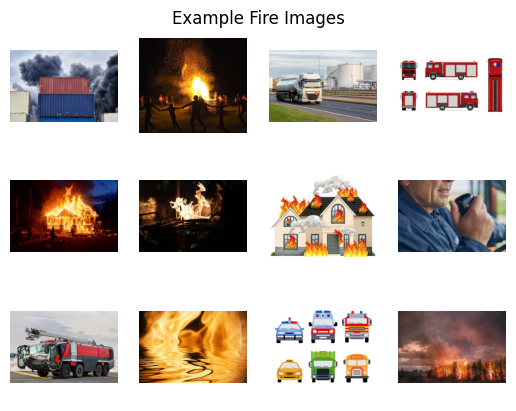

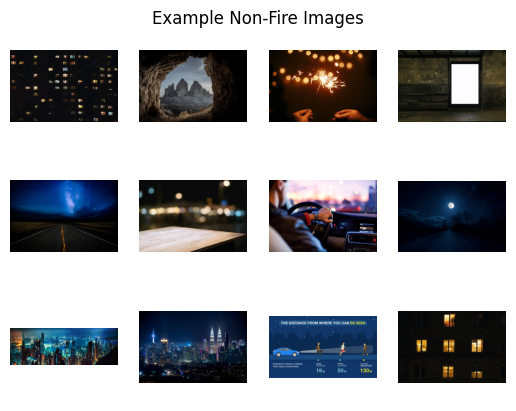

In [35]:
image_collage(train_dir_fire, 3, 4, 'Example Fire Images')
image_collage(train_dir_nofire, 3, 4, 'Example Non-Fire Images')

# Future direction 

- Write more general code for the web scraping.  

- Collecting even more images with even more veriety. 

